In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import aipy

In [5]:
# %load cvcr.py
import numpy as np

def cvcr(f,g, op='timecv'):
    """Convolves or correlates to arrays.
    op is operation type.
    scv = Return array in original array units(convolution thm)
    scr = return correlation between the two arrays by conjugating the second
    hcv = similiar to scv but ignores inverse fourier transform and returns array in 'Hz'
    hcr = similiar to scr but ignores the inverse fourier transform"""
    
    assert (op in ('timecv','timecr','freqcv','freqcr'))
    #fourier transform functions
    f_fft = np.fft.rfft(f)
    g_fft = np.fft.rfft(g)
    fg = f_fft*g_fft
    fgc = f_fft*g_fft.conj()
    if op=='timecv':
        fcvg = np.fft.irfft(fg)
        return fcvg
    elif op=='timecr':
        fcrg = np.fft.irfft(fgc)
        return fcrg
    elif op=='freqcv':
        return fg
    elif op=='freqcr':
        return fgc



In [6]:
# %load delay.py
import numpy as np

def delay(a, dt, mode='wcon'):
    '''Returns a shifted or wrapped array based on mode 
    Example:

    Shifts and wraps (Shifts only integer type delays)
    >>>delay([1,2,3,4,5], 3)
    array([3,4,5,1,2])

    Shifts and adds guassian noise 
    >>>delay([1,2,3,4,5], 3, 'ncon')
    array([randint, randint, randint, 1, 2])

    'wfft' mode will shift and wrap an array via convolution theorem
    This mode can handle float type delays 
    '''
    assert (mode in ('wcon' , 'ncon', 'wfft')) #select mode from list
    assert (0 <= np.abs(dt) < a.size) #delay out of possible range
    
    if mode =='wcon':
        assert(type(dt) in (int, long))#To do float type delays use wfft
        d_a = np.concatenate((a[dt-a.size:],a[:dt]))
        return d_a
    elif mode=='ncon':
        assert(type(dt) in (int, long))#To do float type delays use wfft
        rand = np.random.rand(dt)
        d_a = np.concatenate((rand, a[:-rand.size]), axis=0)
        return d_a
    elif mode=='wfft': # TODO Improve Tolerance
        f_fft=np.fft.fft(a)
        #returns cycles per second if sample spacing of f is in seconds
        nu = np.fft.fftfreq(a.size)
        #Phase shift(kronecker delta)
        phi = np.exp(-2j * np.pi *nu * dt)
        fcvp = np.fft.ifft(phi * f_fft)
        d_a = fcvp.astype(a.dtype)
        return d_a
    
def mult(signals, elem, tau='n'):
    '''This function serves to create multiple arrays that 
    are delayed by some random amount.
    signals: Number of desired signal arrays
    elem: number of elements in signal array
    ld: lowest delay
    hd: highest delay
    '''
    assert tau in ('n' , 'rand', 'choose')
    n = np.random.randn(signals, elem)
    if tau == 'n':
        return n
    if tau == 'rand':
        ld = input('Enter minimum delay: ')
        hd = input('Enter max delay: ')
        for i in range(signals):
            r = np.random.randint(ld, hd)
            n[i]= delay(n[i], r, 'wfft')
        return n
    if tau =='choose':
        for i in range(signals):
            print 'Delay array ' , i+1 , ' by: '
            r = input()
            n[i]= delay(n[i], r, 'wfft')
        return n

def dmul(a, dt=0, mode='wcon'):
    assert (a.shape[1]>0) #dmul only works for array of arrays
    assert mode in ('wcon' , 'rand' , 'wfft')
    for i in range(a.shape[0]):
        if mode =='wfft':
            f_fft=np.fft.fft(a)
            nu = np.fft.fftfreq(a[i].size)
            phi = np.exp(-2j*np.pi*nu*dt)
            fcvp = np.fft.ifft(phi*f_fft)
            d_a = fcvp.real
    return d_a

In [7]:
signal1 = np.random.randn(4000*1024)
signal2 = np.random.randn(4000*1024)

In [8]:
bl1 = np.array([30e2,0,0])
s1 = np.array([np.sqrt(2)/2, 0 , np.sqrt(2)/2])
clk_pr = 5 # ns
tj1 = np.dot(bl1, s1) / aipy.const.len_ns / clk_pr # Delay in samples

In [9]:
s2 = np.array([-np.sqrt(3)/2, 0, .5])
tj2 = np.dot(bl1, s2) / aipy.const.len_ns / clk_pr # Delay in samples 

In [10]:
anti_1 = delay(signal1, 0, 'wfft')
antj_1 = delay(signal1, tj1, 'wfft')
antk_1 = delay(signal1, 2*tj1, 'wfft')
antl_1 = delay(signal1, 3*tj1, 'wfft')

anti_2 = delay(signal2, 0,'wfft')
antj_2 = delay(signal2, tj2, 'wfft')
antk_2 = delay(signal2, 2*tj2, 'wfft')
antl_2 = delay(signal2, 3*tj2, 'wfft')

/home/champ2/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:38: ComplexWarning: Casting complex values to real discards the imaginary part


In [12]:
# axij.plot(ij, c='b', label = 'aicraj')
# axij.plot(ij_, c='g')
# axij.plot(jk, c='r', label = 'ajcrak')
# axij.plot(jk_, c='y')axij.plot(ij, c='b', label = 'aicraj')
# axij.plot(ij_, c='g')
# axij.plot(jk, c='r', label = 'ajcrak')
# axij.plot(jk_, c='y')
s1st=np.random.randint(1,10)
s2st=np.random.randint(1,10)

gi=np.random.uniform(.5,1.5)
gj=np.random.uniform(.5,1.5)
gk=np.random.uniform(.5,1.5)
gl=np.random.uniform(.5,1.5)

In [102]:
# print gi
# print gj
# print gk
# print gl

In [95]:
gi_ = .93179
gj_ = 1.0732
gk_ = 1.09
gl_ = 1

anti_ = gi_*(s1st*anti_1+s2st*anti_2)
antj_ = gj_*(s1st*antj_1+s2st*antj_2)
antk_ = gk_*(s1st*antk_1+s2st*antk_2)
antl_ = gl_*(s1st*antl_1+s2st*antl_2)

anti = gi*(s1st*anti_1+s2st*anti_2)
antj = gj*(s1st*antj_1+s2st*antj_2)
antk = gk*(s1st*antk_1+s2st*antk_2)
antl = gl*(s1st*antl_1+s2st*antl_2)

In [ ]:
fig, (axij) = plt.subplots(1, figsize=(15,4.5))
axij.plot(anti, c='b', label = 'aicraj')
axij.plot(ijvis_, c='g')

In [96]:
for a in (anti, antj , antk, antl, anti_, antj_, antk_, antl_):
    a.shape = (-1,1024)

In [97]:
op='freqcr'
ijcor = cvcr(anti, antj, op)
jkcor = cvcr(antj, antk, op)
klcor = cvcr(antk, antl, op)
ikcor = cvcr(anti, antk, op)
jlcor = cvcr(antj, antl, op)
ilcor = cvcr(anti, antl, op)

ijcor_ = cvcr(anti_, antj_, op)
jkcor_ = cvcr(antj_, antk_, op)
klcor_ = cvcr(antk_, antl_, op)
ikcor_ = cvcr(anti_, antk_, op)
jlcor_ = cvcr(antj_, antl_, op)
ilcor_ = cvcr(anti_, antl_, op)

In [98]:
ijvis = np.average(ijcor, axis=0)
jkvis = np.average(jkcor, axis=0)
klvis = np.average(klcor, axis=0)
ikvis = np.average(ikcor, axis=0)
jlvis = np.average(jlcor, axis=0)
ilvis = np.average(ilcor, axis=0)

ijvis_ = np.average(ijcor_, axis=0)
jkvis_ = np.average(jkcor_, axis=0)
klvis_ = np.average(klcor_, axis=0)
ikvis_ = np.average(ikcor_, axis=0)
jlvis_ = np.average(jlcor_, axis=0)
ilvis_ = np.average(ilcor_, axis=0)

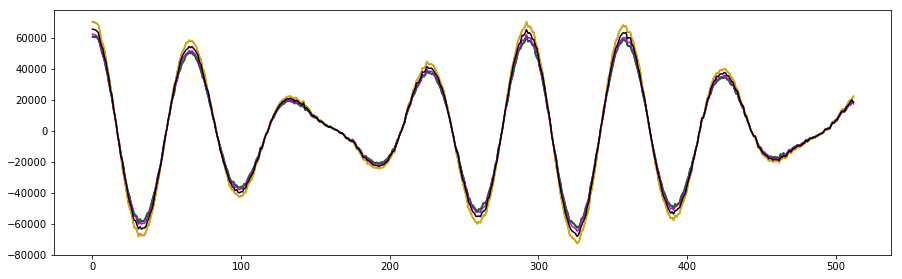

In [103]:
lw =1.5
fig, (axij) = plt.subplots(1, figsize=(15,4.5))
axij.plot(ijvis, c='b', label = 'aicraj')
axij.plot(ijvis_, c='g')
axij.plot(jkvis, c='r', label = 'ajcrak')
axij.plot(jkvis_, c='y')
axij.plot(klvis, c='m', label = 'akcral')
axij.plot(klvis_, c='black')

# axij.set_xlim(50,100)

In [ ]:
axij.plot(ijvis, c='b', label = 'aicraj')
axij.plot(ijvis_, c='g')
axij.plot(jkvis, c='r', label = 'ajcrak')
axij.plot(jkvis_, c='y')
axij.plot(klvis, c='m', label = 'akcral')
axij.plot(klvis_, c='black')

axij.plot(ikvis, c='b', label = 'aicrak')
axij.plot(ikvis_, c='g')
axij.plot(jlvis, c='r', label = 'ajcral')
axij.plot(jlvis_, c='y')

axij.plot(ilvis, c='b', label = 'aicral')
axij.plot(ilvis_, c='g')

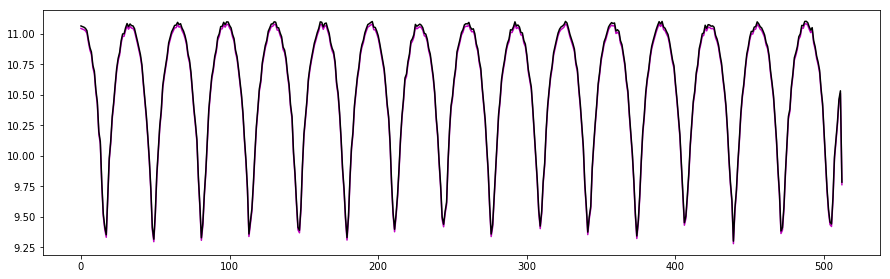

In [94]:
ijlog= np.log(ijvis)
jklog= np.log(jkvis)
kllog= np.log(klvis)
ijlog_= np.log(ijvis_)
jklog_= np.log(jkvis_)
kllog_= np.log(klvis_)+np.log(.97)

lw =1.5
fig, (axij) = plt.subplots(1, figsize=(15,4.5))
# axij.plot(ijlog, c='b', label = 'aicraj')
# axij.plot(ijlog_, c='g')
# axij.plot(jklog, c='r', label = 'ajcrak')
# axij.plot(jklog_, c='y')
axij.plot(kllog, c='m', label = 'akcral')
axij.plot(kllog_, c='black')


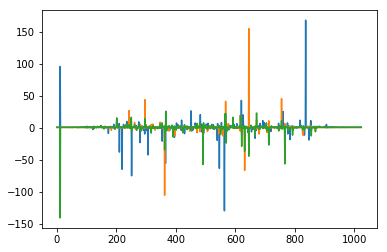

In [28]:
ij_jk = ij/jk
jk_kl = jk/kl
ij_kl = ij/kl

ij[2], jk[2],ij_jk[2]

plt.plot(ij_jk)
plt.plot(jk_kl)
plt.plot(ij_kl)

In [755]:
lvism = np.log(vism)

In [756]:
np.angle((np.sqrt(2) / 2 ) + (np.sqrt(2)/2)*1j)

0.78539816339744828